## Medical data analysis using graphs

In [ ]:
from main import *
import dataframe_image as dfi

pd.set_option('display.max_rows', 150)
pd.set_option('display.max_columns', 150)

studyId = 'nsclc_ctdx_msk_2022'

#### Getting data from local files (downloaded from https://www.cbioportal.org/)

Patient data

In [ ]:
patient_data = get_PatientData(studyId)
display(patient_data)

Sample data

In [ ]:
sample_data = get_SampleData(studyId)
display(sample_data)

Mutation data

In [ ]:
mutation_data = get_MutationData(studyId)
display(mutation_data)

Full data (by merging sample and mutation data)

In [ ]:
full_data = get_FullData(sample_data, mutation_data)
display(full_data)

In [ ]:
# check dbSNP_RS values
full_data.value_counts('dbSNP_RS')

In [ ]:
# check patient ids
full_data.value_counts('PATIENT_ID')

In [ ]:
# check mutation values
full_data.value_counts('MUTATION')

In [ ]:
# check cancer type detailed values
full_data.value_counts('CANCER_TYPE_DETAILED')

Drugs data (from file geni_farmaci.xls)

In [ ]:
drugs_data = get_DrugsData()
display(drugs_data)

#### Building the green graph and working on it

In [ ]:
dip_graph = build_DiPGraph(full_data)
pm_graph = build_PMGraph(full_data, patient_data, sample_data)

In [ ]:
diseases = get_DiNodes(dip_graph)
dd = {'Disease' : [], 'Patient count' : []}
for di in diseases:
    pcnt = len(set(m for m in dip_graph.neighbors(di)))
    dd['Disease'].append(di)
    dd['Patient count'].append(pcnt)
ddf = pd.DataFrame(dd)
ddf.sort_values(by='Patient count', ascending=False, inplace=True)
ddf.reset_index(drop=True, inplace=True)
ddfi = ddf.iloc[:5]
display(ddfi)
#dfi.export(ddfi, f'immagini tesi/{studyId}/malattie.png')
    

In [ ]:
disease = 'Lung Adenocarcinoma'
mcount = dip_graph.degree(disease)
dis_mutations = getMutations_fromDisease(dip_graph, pm_graph, disease, mcount)
print(f'{disease} - {mcount} pazienti')
#dis_mutations = dis_mutations.style.set_caption(f'{disease} - {mcount} patients')
df = dis_mutations.iloc[:10]
display(df)
#dfi.export(df, f'immagini tesi/{studyId}/panadenocarcinoma.png')

#### Clustering

In [25]:
cluster_attributes = ['CANCER_TYPE_DETAILED', 'SEX', 'OS_STATUS', 'OS_MONTHS']
threshold = 1   # imposta ad un numero decimale tra 0 e 1 (compresi)
clusters = clustering(pm_graph, threshold)

Display general cluster view

,Cluster,Numero pazienti,Numero mutazioni
0,0,15,1
1,1,14,1
2,2,10,1
3,3,5,1
4,4,5,1
...,...,...,...
10,10,2,1
11,11,2,1
12,12,2,1
13,13,2,1


930 pazienti
872 cluster totali: 15 cluster con piú di un paziente (73 pazienti), 857 cluster con un paziente


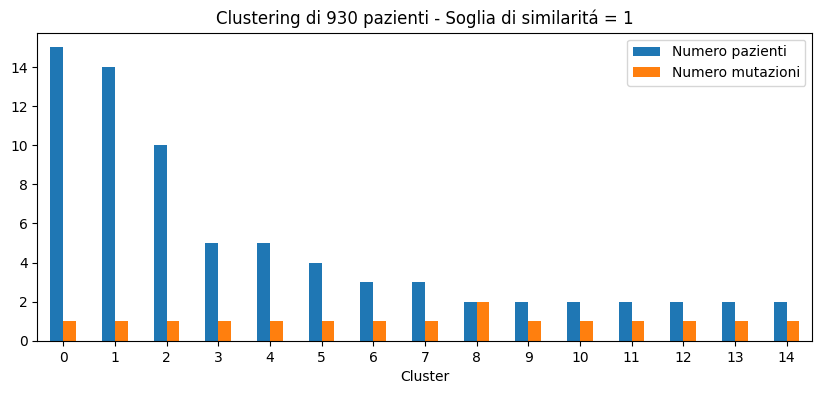

In [31]:
if len(clusters) > 0:
    cluster_view = {'Cluster' : [], 'Numero pazienti' : [], 'Numero mutazioni': []}
    for n, patients in clusters.items():
        cluster_view['Cluster'].append(n)
        cluster_view['Numero pazienti'].append(len(patients))
        leader = patients[0]
        leader_mutations = list(m for m in pm_graph.neighbors(leader))
        cluster_view['Numero mutazioni'].append(len(leader_mutations))
    cluster_view_df = pd.DataFrame(cluster_view)

    total_patients = len(get_PNodes(pm_graph))
    cluster_patients = cluster_view_df['Numero pazienti'].sum()
    ones = total_patients - cluster_patients
    total_clusters = len(clusters) + ones
    cluster_view_df.iloc[:].plot.bar(x='Cluster', rot=0, title=f'Clustering di {total_patients} pazienti - Soglia di similaritá = {threshold}', figsize=(10, 4))
    with pd.option_context('display.max_rows', 10):
        display(cluster_view_df)
    print(f'{total_patients} pazienti\n{total_clusters} cluster totali: {len(clusters)} cluster con piú di un paziente ({cluster_patients} pazienti), {ones} cluster con un paziente')

Display all clusters (or a specific cluster)

In [33]:
cluster_dfs = {}
cluster_model = {'PATIENT' : []}
for attr in cluster_attributes:
    if nx.get_node_attributes(pm_graph, attr):
        cluster_model[attr] = []

for n, patients in clusters.items():
    cluster_data = copy.deepcopy(cluster_model)
    for p in patients:
        for attr in cluster_data.keys():
            if attr == 'PATIENT':
                cluster_data[attr].append(p)
            else:
                cluster_data[attr].append(pm_graph.nodes[p][attr])
    cluster_df = pd.DataFrame(cluster_data)
    cluster_dfs[n] = cluster_df

#dfi.export(cluster_dfs[0], f'immagini tesi/{studyId}/cl0.png')

def show_cluster(number):
    #show = 0    # imposta al numero di cluster che si vuole approfondire o a -1 per vederli tutti
    for n, cluster in cluster_dfs.items():
        if n == number or number == -1:
            cluster_df = cluster.style.set_caption(f'Cluster {n}')
            leader = clusters[n][0]
            leader_mutations = list(m for m in pm_graph.neighbors(leader))
            cluster_mutations = {'MUTATION' : leader_mutations}
            cluster_mutations_df = pd.DataFrame(cluster_mutations)
            #dfi.export(cluster_mutations_df, f'immagini tesi/{studyId}/cl0_mutations.png')
            display(cluster_df)
            display(cluster_mutations_df)
            '''for attr in cluster_attributes:
                if attr == 'OS_MONTHS':
                    cluster[attr].plot.bar(xlabel='Patient', rot=0, title=attr)
                else:
                    cluster[attr].value_counts().plot(kind='pie', autopct='%1.0f%%', title=attr, ylabel='')
                plt.show()'''
            #cluster[attribute].value_counts().plot(kind='pie', autopct='%1.0f%%', title=attribute)

show_cluster(-1)

,PATIENT,CANCER_TYPE_DETAILED,SEX,OS_STATUS,OS_MONTHS
0,MSK-L-130,Lung Adenocarcinoma,Female,1:DECEASED,6.603154
1,MSK-L-173,Lung Adenocarcinoma,Female,1:DECEASED,2.463863
2,MSK-L-296,Lung Squamous Cell Carcinoma,Female,0:LIVING,0.591327
3,MSK-L-310,Lung Adenocarcinoma,Female,1:DECEASED,33.968463
4,MSK-L-355,Lung Adenocarcinoma,Male,0:LIVING,0.427070
5,MSK-L-450,Lung Adenocarcinoma,Female,1:DECEASED,12.220762
6,MSK-L-474,Lung Adenocarcinoma,Male,1:DECEASED,9.855453
7,MSK-L-512,Lung Adenocarcinoma,Female,1:DECEASED,3.942181
8,MSK-L-549,Lung Adenocarcinoma,Male,1:DECEASED,28.515112
9,P-0052012,Lung Squamous Cell Carcinoma,Female,1:DECEASED,7.785808


,MUTATION
0,KRAS_12_25398284_25398284


,PATIENT,CANCER_TYPE_DETAILED,SEX,OS_STATUS,OS_MONTHS
0,MSK-L-159,Lung Adenocarcinoma,Female,1:DECEASED,10.512484
1,P-0027009,Non-Small Cell Lung Cancer,Female,1:DECEASED,13.173456
2,MSK-L-253,Lung Adenocarcinoma,Male,1:DECEASED,12.089356
3,P-0030308,Lung Adenocarcinoma,Male,1:DECEASED,1.938239
4,MSK-L-536,Lung Adenocarcinoma,Female,1:DECEASED,1.478318
5,MSK-L-573,Lung Adenocarcinoma,Female,1:DECEASED,9.264126
6,MSK-L-622,Non-Small Cell Lung Cancer,Male,1:DECEASED,5.124836
7,P-0040363,Lung Adenocarcinoma,Male,1:DECEASED,4.434954
8,MSK-L-841,Lung Adenocarcinoma,Male,0:LIVING,34.756899
9,MSK-L-1090,Lung Adenocarcinoma,Male,1:DECEASED,10.840999


,MUTATION
0,KRAS_12_25398285_25398285


,PATIENT,CANCER_TYPE_DETAILED,SEX,OS_STATUS,OS_MONTHS
0,MSK-L-380,Lung Adenocarcinoma,Female,1:DECEASED,27.890933
1,MSK-L-528,Lung Adenocarcinoma,Female,0:LIVING,0.952694
2,MSK-L-575,Lung Adenocarcinoma,Male,0:LIVING,1.215506
3,MSK-L-688,Lung Adenocarcinoma,Male,0:LIVING,29.993430
4,P-0025344,Lung Adenocarcinoma,Female,0:LIVING,49.408673
5,P-0041215,Lung Adenocarcinoma,Male,0:LIVING,67.805519
6,NCI-L-013,Lung Adenocarcinoma,Female,1:DECEASED,42.509855
7,NCI-L-038,Lung Adenocarcinoma,Female,0:LIVING,0.262812
8,NCI-L-056,Lung Adenocarcinoma,Female,1:DECEASED,14.487516
9,NCI-L-172,Lung Adenocarcinoma,Female,1:DECEASED,29.730618


,MUTATION
0,EGFR_7_55259515_55259515


,PATIENT,CANCER_TYPE_DETAILED,SEX,OS_STATUS,OS_MONTHS
0,P-0017214,Lung Adenocarcinoma,Female,1:DECEASED,45.959264
1,MSK-L-031,Lung Adenocarcinoma,Female,1:DECEASED,21.846255
2,MSK-L-544,Lung Adenocarcinoma,Male,1:DECEASED,15.045992
3,MSK-L-699,Lung Adenocarcinoma,Male,1:DECEASED,23.784494
4,MSK-L-1006,Lung Adenocarcinoma,Female,1:DECEASED,22.700394


,MUTATION
0,TP53_17_7577120_7577120


,PATIENT,CANCER_TYPE_DETAILED,SEX,OS_STATUS,OS_MONTHS
0,MSK-L-143,Lung Adenocarcinoma,Male,1:DECEASED,3.285151
1,P-0025398,Lung Adenocarcinoma,Female,0:LIVING,49.868594
2,MSK-L-195,Lung Adenocarcinoma,Male,1:DECEASED,3.810775
3,P-0052859,Lung Adenocarcinoma,Female,1:DECEASED,28.777924
4,P-0045581,Lung Adenocarcinoma,Female,0:LIVING,24.868594


,MUTATION
0,EGFR_7_55242465_55242479


,PATIENT,CANCER_TYPE_DETAILED,SEX,OS_STATUS,OS_MONTHS
0,MSK-L-172,Lung Adenocarcinoma,Female,1:DECEASED,44.908016
1,MSK-L-679,Lung Adenocarcinoma,Male,0:LIVING,0.065703
2,MSK-L-719,Lung Adenocarcinoma,Male,1:DECEASED,5.913272
3,P-0038442,Lung Adenocarcinoma,Female,0:LIVING,35.479632


,MUTATION
0,TP53_17_7577538_7577538


,PATIENT,CANCER_TYPE_DETAILED,SEX,OS_STATUS,OS_MONTHS
0,P-0022101,Lung Adenocarcinoma,Male,0:LIVING,128.777924
1,MSK-L-074,Lung Adenocarcinoma,Female,1:DECEASED,5.814717
2,MSK-L-177,Lung Adenocarcinoma,Male,0:LIVING,33.541393


,MUTATION
0,TP53_17_7578406_7578406


,PATIENT,CANCER_TYPE_DETAILED,SEX,OS_STATUS,OS_MONTHS
0,MSK-L-262,Lung Adenocarcinoma,Male,0:LIVING,45.499343
1,P-0036090,Lung Adenocarcinoma,Female,0:LIVING,1.971091
2,MSK-L-1181,Lung Adenocarcinoma,Male,1:DECEASED,9.724047


,MUTATION
0,BRAF_7_140453136_140453136


,PATIENT,CANCER_TYPE_DETAILED,SEX,OS_STATUS,OS_MONTHS
0,MSK-L-168,Lung Adenocarcinoma,Male,1:DECEASED,68.791064
1,NCI-L-006,Lung Adenocarcinoma,Male,0:LIVING,32.161629


,MUTATION
0,EGFR_7_55249071_55249071
1,EGFR_7_55242465_55242479


,PATIENT,CANCER_TYPE_DETAILED,SEX,OS_STATUS,OS_MONTHS
0,MSK-L-023,Non-Small Cell Lung Cancer,Female,0:LIVING,1.149803
1,MSK-L-052,Lung Adenocarcinoma,Female,1:DECEASED,16.819974


,MUTATION
0,MET_7_116412043_116412043


,PATIENT,CANCER_TYPE_DETAILED,SEX,OS_STATUS,OS_MONTHS
0,MSK-L-261,Lung Adenocarcinoma,Female,1:DECEASED,21.090670
1,MSK-L-848,Lung Adenocarcinoma,Female,1:DECEASED,25.295664


,MUTATION
0,TP53_17_7578190_7578190


,PATIENT,CANCER_TYPE_DETAILED,SEX,OS_STATUS,OS_MONTHS
0,MSK-L-309,Lung Adenocarcinoma,Male,1:DECEASED,0.262812
1,MSK-L-574,Non-Small Cell Lung Cancer,Female,0:LIVING,4.303548


,MUTATION
0,TP53_17_7578208_7578208


,PATIENT,CANCER_TYPE_DETAILED,SEX,OS_STATUS,OS_MONTHS
0,MSK-L-546,Non-Small Cell Lung Cancer,Female,1:DECEASED,0.952694
1,NCI-L-016,Lung Adenocarcinoma,Female,1:DECEASED,31.800263


,MUTATION
0,TP53_17_7577580_7577580


,PATIENT,CANCER_TYPE_DETAILED,SEX,OS_STATUS,OS_MONTHS
0,MSK-L-811,Lung Adenocarcinoma,Male,0:LIVING,1.018397
1,P-0007534,Lung Adenocarcinoma,Male,0:LIVING,75.229961


,MUTATION
0,MET_7_116412045_116412045


,PATIENT,CANCER_TYPE_DETAILED,SEX,OS_STATUS,OS_MONTHS
0,P-0043746,Lung Adenocarcinoma,Male,0:LIVING,5.716163
1,P-0031598,Lung Adenocarcinoma,Female,0:LIVING,2.036794


,MUTATION
0,ERBB2_17_37880997_37880998
